## Plan

This jupyter notebook breaks down the flow of using OCHRE for building 
envelope system identification

In [1]:
#function needed:
import pandas as pd

def attach_epw_to_df(df, epw_path,
                     keep_cols=("Dry Bulb (C)",
                                "Relative Humidity (%)",
                                "Global Horizontal Radiation (Wh/m^2)",
                                "Wind Speed (m/s)"),
                     out_names=("Temperature - Outdoor (C) [EPW]",
                                "Relative Humidity - Outdoor (%) [EPW]",
                                "Global Horizontal Irradiance (W/m^2) [EPW]",  # EPW is Wh/m² (hourly avg)
                                "Wind Speed - Outdoor (m/s) [EPW]")):
    # --- read EPW ---
    cols = [
        "Year","Month","Day","Hour","Minute","Flags",
        "Dry Bulb (C)","Dew Point (C)","Relative Humidity (%)","Atmos Pressure (Pa)",
        "Extraterrestrial Horizontal Radiation (Wh/m^2)",
        "Extraterrestrial Direct Normal Radiation (Wh/m^2)",
        "Horizontal IR Intensity (Wh/m^2)",
        "Global Horizontal Radiation (Wh/m^2)",
        "Direct Normal Radiation (Wh/m^2)",
        "Diffuse Horizontal Radiation (Wh/m^2)",
        "Global Horizontal Illuminance (lux)",
        "Direct Normal Illuminance (lux)",
        "Diffuse Horizontal Illuminance (lux)",
        "Zenith Luminance (Cd/m^2)",
        "Wind Direction (deg)","Wind Speed (m/s)","Total Sky Cover (tenths)",
        "Opaque Sky Cover (tenths)","Visibility (km)","Ceiling Height (m)",
        "Present Weather Observation","Present Weather Codes",
        "Precipitable Water (mm)","Aerosol Optical Depth (thousandths)",
        "Snow Depth (cm)","Days Since Last Snowfall",
        "Albedo","Liquid Precipitation Depth (mm)","Liquid Precipitation Quantity (hr)"
    ]
    epw = pd.read_csv(epw_path, skiprows=8, header=None, names=cols)

    # --- Build timestamp ignoring EPW 'Year' ---
    # EPW Hour = 1..24 marks END of hour → convert to start of hour
    h = epw["Hour"].to_numpy()
    carry = (h == 24).astype(int)
    hour0 = (h % 24)

    # choose a single year: the sim's year
    sim_year = int(df.index[0].year)

    dt = pd.to_datetime({
        "year": sim_year,                            # force a single year
        "month": epw["Month"],
        "day": epw["Day"],
        "hour": hour0,
        # EPW minute is usually 0 for hourly TMY; include if present
        "minute": epw["Minute"] if "Minute" in epw else 0
    })
    # shift hour=24 rows to next day (now within the same sim_year)
    dt = dt + pd.to_timedelta(carry, unit="D")

    wx = epw.set_index(dt)[list(keep_cols)].copy()
    wx.columns = list(out_names)

    # RH sanity
    if "Relative Humidity - Outdoor (%) [EPW]" in wx:
        wx["Relative Humidity - Outdoor (%) [EPW]"] = wx["Relative Humidity - Outdoor (%) [EPW]"].clip(0, 100)

    # Align to sim timeline; hourly → sub-hourly via forward-fill
    # If df has irregular start (e.g., not exactly at :00), also bfill edges.
    wx_aligned = wx.reindex(df.index, method="ffill").bfill()

    # Join
    out = df.join(wx_aligned, how="left")
    return out




## Step 1
Initialize the building and weather data. Note, how scheduling is also 
initialized, but this is for other power loads in the house (washer, dryer, 
etc.) 

In [2]:
import os
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ochre import CreateFigures
from ochre import Dwelling
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
default_input_path = os.path.join(PROJECT_ROOT, "ochre", "defaults")

timestep_sim = 1 # timestep of simulation in minutes

dwelling_args = {
    # Timing parameters
    "start_time": dt.datetime(2018, 1, 1, 0, 0),  # (year, month, day, hour, 
    # minute)
    "time_res": dt.timedelta(minutes=timestep_sim),         # time resolution
    # of the simulation
    "duration": dt.timedelta(days=1),             # duration of the 
    # simulation to just initialize. Will change later
    "verbosity": 6,

    # Input files
    "hpxml_file": os.path.join(default_input_path, "Input Files", 
                               "bldg0112631-up11.xml"),
    "hpxml_schedule_file": os.path.join(default_input_path, "Input Files", "bldg0112631_schedule.csv"),
    "weather_file": os.path.join(default_input_path, "Weather", "USA_CO_Denver.Intl.AP.725650_TMY3.epw"),
}

# Create Dwelling model
dwelling = Dwelling(**dwelling_args)
heater = dwelling.get_equipment_by_end_use("HVAC Heating")
schedule = heater.schedule
schedule["HVAC Heating Deadband (C)"] = 2
peak_times = (schedule.index.hour >= 10) & (schedule.index.hour < 15)
schedule.loc[peak_times, "HVAC Heating Setpoint (C)"] -= 3

heater.min_on_time = 600*2          # min cycle on for 
heater.min_off_time = 600*2         # min cycle off for

heater.reset_time()

df, metrics, hourly = dwelling.simulate()

2025-10-31 11:30:45.694590 - ochre at 2018-01-01 00:00:00: Initializing ochre (OCHRE v0.9.1)
2025-10-31 11:30:45.694833 - ochre at 2018-01-01 00:00:00: Removing previous results file: /Users/levipremer/PycharmProjects/OCHRE_test/ochre/defaults/Input Files/ochre.csv
2025-10-31 11:30:45.697804 - ochre at 2018-01-01 00:00:00: Removing previous results file: /Users/levipremer/PycharmProjects/OCHRE_test/ochre/defaults/Input Files/ochre_metrics.csv
2025-10-31 11:30:45.697893 - ochre at 2018-01-01 00:00:00: Removing previous results file: /Users/levipremer/PycharmProjects/OCHRE_test/ochre/defaults/Input Files/ochre_hourly.csv
2025-10-31 11:30:45.697992 - ochre at 2018-01-01 00:00:00: Removing previous results file: /Users/levipremer/PycharmProjects/OCHRE_test/ochre/defaults/Input Files/ochre_schedule.csv
2025-10-31 11:30:47.240806 - ochre at 2018-01-01 00:00:00: Dwelling Initialized
2025-10-31 11:30:47.242628 - ochre at 2018-01-01 00:00:00: Running Simulation for 1 day, 0:00:00
2025-10-31 11:

In [3]:
dwelling

In [4]:
df.head()

,Total Electric Power (kW),Total Reactive Power (kVAR),Total Gas Power (therms/hour),Total Electric Energy (kWh),Total Reactive Energy (kVARh),Total Gas Energy (therms),HVAC Cooling Electric Power (kW),Water Heating Electric Power (kW),Lighting Electric Power (kW),HVAC Heating Electric Power (kW),...,Temperature - Ground (C),Net Sensible Heat Gain - Indoor (W),Net Sensible Heat Gain - Foundation (W),Net Sensible Heat Gain - Garage (W),Net Sensible Heat Gain - Attic (W),Infiltration Heat Gain - Indoor (W),Forced Ventilation Heat Gain - Indoor (W),Natural Ventilation Heat Gain - Indoor (W),Internal Heat Gain - Indoor (W),Window Transmitted Solar Gain (W)
Time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,0.29796,0.187849,0.0,0.004966,0.003131,0.0,0.05,0.001,0.016273,0.0,...,6.529479,-3234.197179,-3157.025931,-7240.811301,-310.210724,-3578.392666,-0.0,-0.0,365.640333,0.0
2018-01-01 00:01:00,0.29796,0.187849,0.0,0.004966,0.003131,0.0,0.05,0.001,0.016273,0.0,...,6.529479,-3210.218689,-3079.732433,-7055.657737,-292.755506,-3560.331869,-0.0,-0.0,365.640333,0.0
2018-01-01 00:02:00,0.29796,0.187849,0.0,0.004966,0.003131,0.0,0.05,0.001,0.016273,0.0,...,6.529479,-3187.425448,-3012.066928,-6887.029134,-290.824793,-3542.804981,-0.0,-0.0,365.640333,0.0
2018-01-01 00:03:00,0.29796,0.187849,0.0,0.004966,0.003131,0.0,0.05,0.001,0.016273,0.0,...,6.529479,-3165.139969,-2948.488956,-6724.990990,-287.534525,-3525.788390,-0.0,-0.0,365.640333,0.0
2018-01-01 00:04:00,0.29796,0.187849,0.0,0.004966,0.003131,0.0,0.05,0.001,0.016273,0.0,...,6.529479,-3143.599224,-2888.973822,-6569.929335,-284.277552,-3509.259999,-0.0,-0.0,365.640333,0.0


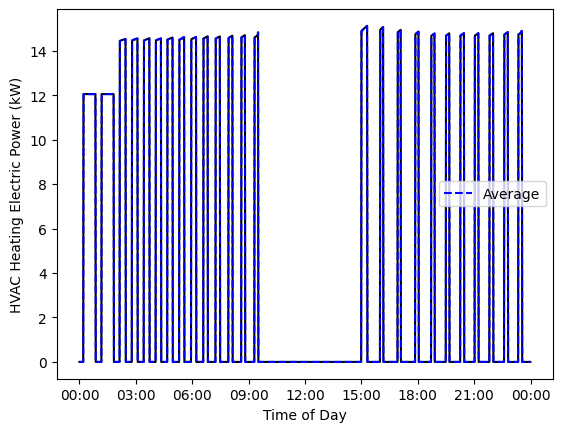

In [5]:
fig = CreateFigures.plot_daily_profile(df, 'HVAC Heating Electric Power (kW)', 
                                       plot_max=False, plot_min=False)

<Axes: xlabel='Time'>

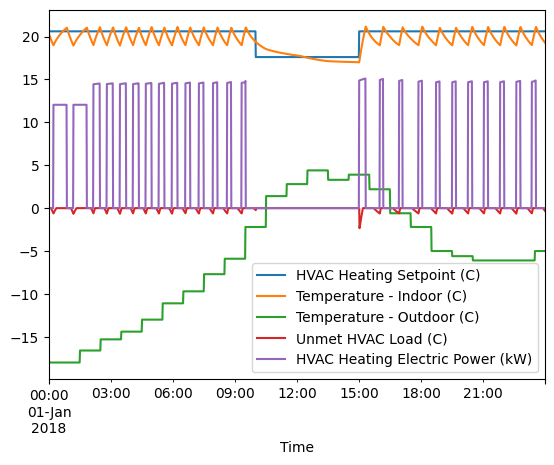

In [6]:
cols_to_plot = [
    "HVAC Heating Setpoint (C)",
    "Temperature - Indoor (C)",
    "Temperature - Outdoor (C)",
    "Unmet HVAC Load (C)",
    "HVAC Heating Electric Power (kW)",
]
df.loc[:, cols_to_plot].plot()

## Create training dataset
This portion will segment data to be trained on. This represents the "real" 
homes data. 

Input the number of training days you want.

In [7]:
train_days = 30

dwelling_args.update({
    "start_time": dt.datetime(2018, 1, 1, 0, 0),
    "duration": dt.timedelta(days=30),
    "verbosity": 9
    }
)

# Create Dwelling model
dwelling_train = Dwelling(**dwelling_args)
heater = dwelling_train.get_equipment_by_end_use("HVAC Heating")
schedule = heater.schedule
schedule["HVAC Heating Deadband (C)"] = 2
peak_times = (schedule.index.hour >= 10) & (schedule.index.hour < 15)
schedule.loc[peak_times, "HVAC Heating Setpoint (C)"] -= 3

heater.min_on_time = 600 * 2  # min cycle on for 
heater.min_off_time = 600 * 2  # min cycle off for

heater.reset_time()

df_train, metrics_train, hourly_train = dwelling_train.simulate()

2025-10-31 11:30:48.188427 - ochre at 2018-01-01 00:00:00: Initializing ochre (OCHRE v0.9.1)
2025-10-31 11:30:48.189218 - ochre at 2018-01-01 00:00:00: Removing previous results file: /Users/levipremer/PycharmProjects/OCHRE_test/ochre/defaults/Input Files/ochre.csv
2025-10-31 11:30:48.193753 - ochre at 2018-01-01 00:00:00: Removing previous results file: /Users/levipremer/PycharmProjects/OCHRE_test/ochre/defaults/Input Files/ochre_metrics.csv
2025-10-31 11:30:48.193917 - ochre at 2018-01-01 00:00:00: Removing previous results file: /Users/levipremer/PycharmProjects/OCHRE_test/ochre/defaults/Input Files/ochre_hourly.csv
2025-10-31 11:30:51.057323 - ochre at 2018-01-01 00:00:00: Saved schedule to: /Users/levipremer/PycharmProjects/OCHRE_test/ochre/defaults/Input Files/ochre_schedule.csv
2025-10-31 11:30:51.453102 - ochre at 2018-01-01 00:00:00: Dwelling Initialized
2025-10-31 11:30:51.476645 - ochre at 2018-01-01 00:00:00: Running Simulation for 30 days, 0:00:00
2025-10-31 11:31:14.43117

In [8]:
df_train_with_weather = attach_epw_to_df(df_train, 
                                         dwelling_args["weather_file"])

In [9]:
df_train.head()

,Total Electric Power (kW),Total Reactive Power (kVAR),Total Gas Power (therms/hour),Total Electric Energy (kWh),Total Reactive Energy (kVARh),Total Gas Energy (therms),HVAC Cooling Electric Power (kW),Water Heating Electric Power (kW),Lighting Electric Power (kW),HVAC Heating Electric Power (kW),...,Garage Furniture Garage Film Coefficient (m^2-K/W),Attic Wall Attic LWR Gain (W),Attic Wall Attic Surface Temperature (C),Attic Wall Attic Film Coefficient (m^2-K/W),Attic Roof Attic LWR Gain (W),Attic Roof Attic Surface Temperature (C),Attic Roof Attic Film Coefficient (m^2-K/W),Attic Floor Attic LWR Gain (W),Attic Floor Attic Surface Temperature (C),Attic Floor Attic Film Coefficient (m^2-K/W)
Time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,0.29796,0.187849,0.0,0.004966,0.003131,0.0,0.05,0.001,0.016273,0.0,...,0.325486,22.309686,-16.256040,0.325486,206.911467,-16.386411,0.536264,-229.221153,-15.255291,0.561134
2018-01-01 00:01:00,0.29796,0.187849,0.0,0.004966,0.003131,0.0,0.05,0.001,0.016273,0.0,...,0.325486,20.571307,-16.233508,0.325486,189.203949,-16.349772,0.536264,-209.775257,-15.314849,0.561134
2018-01-01 00:02:00,0.29796,0.187849,0.0,0.004966,0.003131,0.0,0.05,0.001,0.016273,0.0,...,0.325486,20.527204,-16.235591,0.325486,189.397536,-16.353086,0.536264,-209.924739,-15.317247,0.561134
2018-01-01 00:03:00,0.29796,0.187849,0.0,0.004966,0.003131,0.0,0.05,0.001,0.016273,0.0,...,0.325486,20.439605,-16.239104,0.325486,187.824788,-16.354216,0.536264,-208.264393,-15.326690,0.561134
2018-01-01 00:04:00,0.29796,0.187849,0.0,0.004966,0.003131,0.0,0.05,0.001,0.016273,0.0,...,0.325486,20.227603,-16.247370,0.325486,186.303508,-16.362352,0.536264,-206.531110,-15.343128,0.561134


In [10]:
df_train_with_weather.head()

,Total Electric Power (kW),Total Reactive Power (kVAR),Total Gas Power (therms/hour),Total Electric Energy (kWh),Total Reactive Energy (kVARh),Total Gas Energy (therms),HVAC Cooling Electric Power (kW),Water Heating Electric Power (kW),Lighting Electric Power (kW),HVAC Heating Electric Power (kW),...,Attic Roof Attic LWR Gain (W),Attic Roof Attic Surface Temperature (C),Attic Roof Attic Film Coefficient (m^2-K/W),Attic Floor Attic LWR Gain (W),Attic Floor Attic Surface Temperature (C),Attic Floor Attic Film Coefficient (m^2-K/W),Temperature - Outdoor (C) [EPW],Relative Humidity - Outdoor (%) [EPW],Global Horizontal Irradiance (W/m^2) [EPW],Wind Speed - Outdoor (m/s) [EPW]
Time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,0.29796,0.187849,0.0,0.004966,0.003131,0.0,0.05,0.001,0.016273,0.0,...,206.911467,-16.386411,0.536264,-229.221153,-15.255291,0.561134,-18.0,85.0,0.0,0.0
2018-01-01 00:01:00,0.29796,0.187849,0.0,0.004966,0.003131,0.0,0.05,0.001,0.016273,0.0,...,189.203949,-16.349772,0.536264,-209.775257,-15.314849,0.561134,-18.0,85.0,0.0,0.0
2018-01-01 00:02:00,0.29796,0.187849,0.0,0.004966,0.003131,0.0,0.05,0.001,0.016273,0.0,...,189.397536,-16.353086,0.536264,-209.924739,-15.317247,0.561134,-18.0,85.0,0.0,0.0
2018-01-01 00:03:00,0.29796,0.187849,0.0,0.004966,0.003131,0.0,0.05,0.001,0.016273,0.0,...,187.824788,-16.354216,0.536264,-208.264393,-15.326690,0.561134,-18.0,85.0,0.0,0.0
2018-01-01 00:04:00,0.29796,0.187849,0.0,0.004966,0.003131,0.0,0.05,0.001,0.016273,0.0,...,186.303508,-16.362352,0.536264,-206.531110,-15.343128,0.561134,-18.0,85.0,0.0,0.0


Isolate the training data-set needed for envelope training.

In [11]:
df_envelope_train = df_train_with_weather[["HVAC Heating Electric Power (kW)", 
                              "HVAC Heating ER Power (kW)", 
                              "HVAC Heating Fan Power (kW)",
                              "HVAC Heating Delivered (W)",
                              "HVAC Heating Setpoint (C)",
                              "HVAC Cooling Setpoint (C)",
                              "HVAC Cooling Electric Power (kW)",
                              "HVAC Cooling Delivered (W)",
                              "Temperature - Indoor (C)", 
                              "Relative Humidity - Indoor (-)", 
                              "Temperature - Outdoor (C)",
                              "Temperature - Outdoor (C) [EPW]", 
                              "Global Horizontal Irradiance (W/m^2) [EPW]",
                              "Relative Humidity - Outdoor (%) [EPW]",
                              "Wind Speed - Outdoor (m/s) [EPW]"]]


In [12]:
df_envelope_train_1min = df_envelope_train
df_envelope_train.head()
#df_envelope_train["Temperature - Outdoor (C) [EPW]"].plot()

,HVAC Heating Electric Power (kW),HVAC Heating ER Power (kW),HVAC Heating Fan Power (kW),HVAC Heating Delivered (W),HVAC Heating Setpoint (C),HVAC Cooling Setpoint (C),HVAC Cooling Electric Power (kW),HVAC Cooling Delivered (W),Temperature - Indoor (C),Relative Humidity - Indoor (-),Temperature - Outdoor (C),Temperature - Outdoor (C) [EPW],Global Horizontal Irradiance (W/m^2) [EPW],Relative Humidity - Outdoor (%) [EPW],Wind Speed - Outdoor (m/s) [EPW]
Time,,,,,,,,,,,,,,,
2018-01-01 00:00:00,0.0,0.0,0.0,0.0,20.611111,21.611111,0.05,0.0,20.293399,0.045400,-18.0,-18.0,0.0,85.0,0.0
2018-01-01 00:01:00,0.0,0.0,0.0,0.0,20.611111,21.611111,0.05,0.0,20.176147,0.044934,-18.0,-18.0,0.0,85.0,0.0
2018-01-01 00:02:00,0.0,0.0,0.0,0.0,20.611111,21.611111,0.05,0.0,20.062137,0.045278,-18.0,-18.0,0.0,85.0,0.0
2018-01-01 00:03:00,0.0,0.0,0.0,0.0,20.611111,21.611111,0.05,0.0,19.951233,0.045616,-18.0,-18.0,0.0,85.0,0.0
2018-01-01 00:04:00,0.0,0.0,0.0,0.0,20.611111,21.611111,0.05,0.0,19.843309,0.045949,-18.0,-18.0,0.0,85.0,0.0


## Training dataset is ready to use
Training dataset is prepared. You can further exclude other variables to 
better represent the available measurements in a home. For example, it is 
unlikely to get the total heat delivered and total cooling delivered. You 
will likely only have power measurements, or indicators that the unit is on 
or off.

In the training dataset, there is:
HVAC power (including resistance heat) (kW), HVAC Heating ER Power (kW), HVAC 
Fan power (kW), HVAC Heating delivered (W), Indoor zone temperature (C), Indoor 
relative humidity (-),  Outdoor temperature (C), Outdoor relative humidity (-), 
Global horizontal irradiance (W/m^2), and Outdoor wind speed (m/s)

dataframe: df_envelope_train

Choose what time-step you would like for training

In [13]:
timestep_train = 60 #minutes
dt_train = timestep_train/60 #convert to hours
df_envelope_train = df_envelope_train.resample(f'{timestep_train}min').mean()

In [14]:
df_envelope_train.head()
#df_envelope_train["Temperature - Indoor (C)"].plot()

,HVAC Heating Electric Power (kW),HVAC Heating ER Power (kW),HVAC Heating Fan Power (kW),HVAC Heating Delivered (W),HVAC Heating Setpoint (C),HVAC Cooling Setpoint (C),HVAC Cooling Electric Power (kW),HVAC Cooling Delivered (W),Temperature - Indoor (C),Relative Humidity - Indoor (-),Temperature - Outdoor (C),Temperature - Outdoor (C) [EPW],Global Horizontal Irradiance (W/m^2) [EPW],Relative Humidity - Outdoor (%) [EPW],Wind Speed - Outdoor (m/s) [EPW]
Time,,,,,,,,,,,,,,,
2018-01-01 00:00:00,7.830684,7.607848,0.222836,6077.368712,20.611111,21.611111,0.05,0.0,20.102101,0.045899,-18.00,-18.0,0.0,85.0,0.0
2018-01-01 01:00:00,7.830684,7.607848,0.222836,6077.368712,20.611111,21.611111,0.05,0.0,20.073031,0.047425,-17.30,-18.0,0.0,85.0,0.0
2018-01-01 02:00:00,7.485723,6.047263,0.177126,6389.858965,20.611111,21.611111,0.05,0.0,19.886070,0.049613,-15.95,-16.6,0.0,83.0,0.0
2018-01-01 03:00:00,5.806498,4.681752,0.137130,4987.988892,20.611111,21.611111,0.05,0.0,20.128518,0.050766,-14.85,-15.3,0.0,85.0,0.0
2018-01-01 04:00:00,8.232226,6.632483,0.194268,7125.200512,20.611111,21.611111,0.05,0.0,19.996243,0.053519,-13.70,-14.4,0.0,90.0,0.0


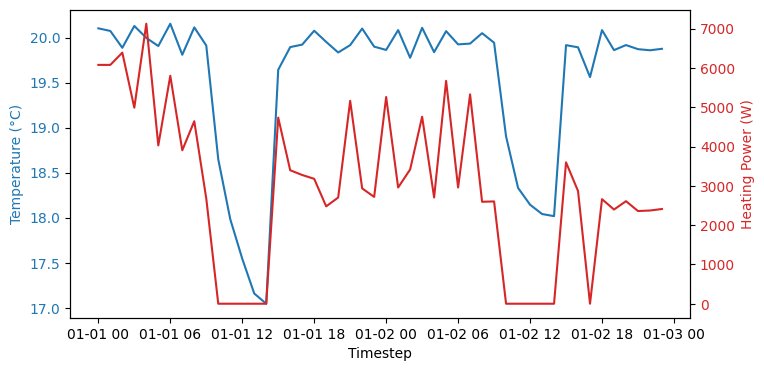

In [15]:
t_end = int(48/dt_train)
#t_end = 1440
fig, ax1 = plt.subplots(figsize=(8, 4))
# Plot Indoor Temperature on the left y-axis
color1 = 'tab:blue'
ax1.plot(df_envelope_train["Temperature - Indoor (C)"].iloc[0:t_end],
         color=color1, label='Indoor Temperature (°C)')
ax1.set_xlabel('Timestep')
ax1.set_ylabel('Temperature (°C)', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot Heating Power on the right y-axis
color2 = 'tab:red'
ax2.plot(df_envelope_train["HVAC Heating Delivered (W)"].iloc[0:t_end],
         color=color2, label='HVAC Heating Delivered (W)')
ax2.set_ylabel('Heating Power (W)', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

plt.show()


## Implement Hankel Predictor

RC training used as an example

In [16]:
df_heating_annual_night = df_envelope_train.copy()
df_heating_annual_night['Hour'] = df_envelope_train.index.hour

# Define night and day conditions
# Condition 1: Time is between 10 PM and 6 AM
night_time_condition = (df_heating_annual_night['Hour'] >= 20) | \
                       (df_heating_annual_night['Hour'] < 6)

# Condition 2: Solar Irradiation is 0 (assuming 'SolarRadiation' is the correct column name)
if 'Global Horizontal Irradiance (W/m^2) [EPW]' in df_heating_annual_night.columns:
    night_solar_condition = (df_heating_annual_night['Global Horizontal Irradiance (W/m^2) [EPW]'] == 0)
    df_heating_annual_night['is_night'] = night_time_condition & night_solar_condition
else:
    print("\nWarning: 'Global Horizontal Irradiance (W/m^2) [EPW]' column not found after preprocessing. Cannot use it for night/day split.")
    df_heating_annual_night['is_night'] = night_time_condition # Fallback to just time condition

df_heating_annual_night['is_night']

Time
2018-01-01 00:00:00     True
2018-01-01 01:00:00     True
2018-01-01 02:00:00     True
2018-01-01 03:00:00     True
2018-01-01 04:00:00     True
                       ...  
2018-01-30 19:00:00    False
2018-01-30 20:00:00     True
2018-01-30 21:00:00     True
2018-01-30 22:00:00     True
2018-01-30 23:00:00     True
Freq: 60min, Name: is_night, Length: 720, dtype: bool

In [17]:
boolean_night = df_heating_annual_night['is_night'].astype(int)
boolean_night

Time
2018-01-01 00:00:00    1
2018-01-01 01:00:00    1
2018-01-01 02:00:00    1
2018-01-01 03:00:00    1
2018-01-01 04:00:00    1
                      ..
2018-01-30 19:00:00    0
2018-01-30 20:00:00    1
2018-01-30 21:00:00    1
2018-01-30 22:00:00    1
2018-01-30 23:00:00    1
Freq: 60min, Name: is_night, Length: 720, dtype: int64

In [18]:

T_in = df_envelope_train["Temperature - Indoor (C)"].to_numpy()
Y = np.diff(T_in) / float(dt_train)  

X1 = df_envelope_train["HVAC Heating Delivered (W)"].to_numpy()[:-1] / 1000.0
X2 = (df_envelope_train["Temperature - Outdoor (C)"].to_numpy()
      - df_envelope_train["Temperature - Indoor (C)"].to_numpy())[:-1]
X3 = df_envelope_train["Global Horizontal Irradiance (W/m^2) [EPW]"].to_numpy()[:-1] / 1000.0
X4 = boolean_night.to_numpy()[:-1].astype(float)
X = np.column_stack((X1, X2, X3, X4))


In [19]:
'''
T_in = df_envelope_train["Temperature - Indoor (C)"].to_numpy()
Y = np.diff(T_in) / float(dt_train)  

X1 = df_envelope_train["HVAC Heating Delivered (W)"].to_numpy()[:-1] / 1000.0
X2 = (df_envelope_train["Temperature - Outdoor (C)"].to_numpy()
      - df_envelope_train["Temperature - Indoor (C)"].to_numpy())[:-1]
X3 = np.ones_like(X2)
X = np.column_stack((X1, X2, X3))
'''

'\nT_in = df_envelope_train["Temperature - Indoor (C)"].to_numpy()\nY = np.diff(T_in) / float(dt_train)  \n\nX1 = df_envelope_train["HVAC Heating Delivered (W)"].to_numpy()[:-1] / 1000.0\nX2 = (df_envelope_train["Temperature - Outdoor (C)"].to_numpy()\n      - df_envelope_train["Temperature - Indoor (C)"].to_numpy())[:-1]\nX3 = np.ones_like(X2)\nX = np.column_stack((X1, X2, X3))\n'

In [20]:
def hankel_matrix(data,L):
    """
    Construct a block Hankel matrix of depth L from time-series data.

    Parameters
    ----------
    data : np.ndarray, shape (T, d)
        The time series (each row is a timestep, each column a variable).
    L : int
        The number of block rows (window length).

    Returns
    -------
    H : np.ndarray, shape (L*d, T - L + 1)
        The block Hankel matrix.
    d : the corresponding channels for the data 
    """
    data_new = np.atleast_2d(data)
    if data_new.shape[0] == 1:
        data = data_new.T
    
    T,d = data.shape
    cols = T-L+1
    H = np.zeros((L*d,cols))
    for i in range(L):
        H[i*d:(i+1)*d, :] = data[i:i+cols, :].T
    return H,d

In [21]:
# --- Choose horizons ----------------------------------
T_ini = int(24*3*dt_train)      # past window length
N = 24          # prediction horizon
L = T_ini + N   # total Hankel depth

In [22]:
# Split raw time series first (avoid overlapping columns across sets)
T_total = len(X)
T_train = int(0.8*T_total)

X_train, Y_train = X[:T_train], Y[:T_train]
X_test,  Y_test  = X[T_train - (L-1):], Y[T_train - (L-1):]  

U_H_tr,m = hankel_matrix(X_train, L)
Y_H_tr,p = hankel_matrix(Y_train, L)

U_H_te,m = hankel_matrix(X_test, L)
Y_H_te,p = hankel_matrix(Y_test, L)

# Partition into past/future block rows
U_p_tr = U_H_tr[:T_ini * m, :]
U_f_tr = U_H_tr[T_ini * m:, :]
Y_p_tr = Y_H_tr[:T_ini * p, :]
Y_f_tr = Y_H_tr[T_ini * p:, :]

U_p_te = U_H_te[:T_ini * m, :]
U_f_te = U_H_te[T_ini * m:, :]
Y_p_te = Y_H_te[:T_ini * p, :]
Y_f_te = Y_H_te[T_ini * p:, :]



In [23]:
# Pick a test column k
k = U_H_te.shape[1] - 1
U_p_te = U_H_te[:T_ini*m, [k]]
Y_p_te = Y_H_te[:T_ini*p, [k]]
U_f_te = U_H_te[T_ini*m:, [k]]
Y_f_te = Y_H_te[T_ini*p:, [k]]  # ground truth

# Solve with *train* columns only
H_tr = np.vstack([U_p_tr, Y_p_tr, U_f_tr])
rhs  = np.vstack([U_p_te, Y_p_te, U_f_te]).ravel()

lam = 1e-6
g = np.linalg.solve(H_tr.T @ H_tr + lam*np.eye(H_tr.shape[1]), H_tr.T @ rhs)
y_pred = (Y_f_tr @ g).reshape(N, p)
y_true = Y_f_te.reshape(N, p)

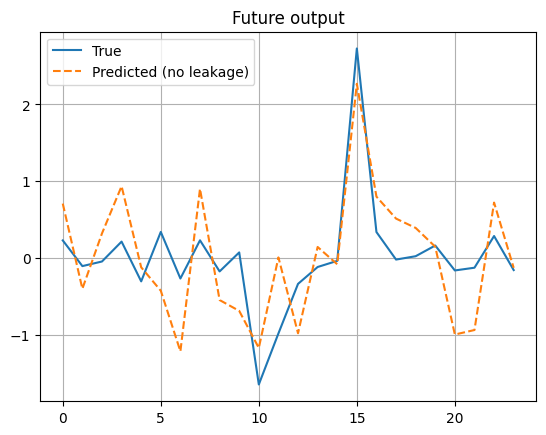

RMSE per output: [0.56834916]


In [24]:
t = np.arange(N)
plt.plot(t, y_true, label="True")
plt.plot(t, y_pred, "--", label="Predicted (no leakage)")
plt.legend(); plt.grid(True); plt.title("Future output"); plt.show()

rmse = np.sqrt(np.mean((y_pred - y_true)**2, axis=0))
print("RMSE per output:", rmse)
                # true future output


In [25]:
g

array([ 1.15275920e-01,  4.34568318e-02,  7.35286593e-02,  5.90666382e-02,
       -1.21173798e-01,  8.38874796e-02, -6.48686151e-02,  8.80445833e-02,
       -2.83648869e-01, -1.49851172e-01, -8.86997112e-02,  1.54538783e-01,
        4.41051525e-02,  3.14752384e-02,  2.97304254e-01, -1.03304251e-02,
        1.22832908e-01, -2.51579179e-02,  2.25242820e-01, -7.97102803e-02,
       -8.58252035e-02, -2.03666171e-01,  1.05124967e-01, -1.05456538e-01,
       -5.69791953e-02, -6.60936346e-02,  2.11800194e-02, -1.65941627e-01,
        1.55290217e-01, -1.33778699e-01,  3.00484305e-02, -1.64986448e-01,
       -3.93871702e-02, -2.25519317e-02,  5.38095173e-02,  1.01797607e-01,
       -1.69395446e-01,  1.63980794e-02,  1.75329270e-02,  6.76129474e-02,
       -1.37546673e-01,  4.42232579e-02,  1.12394358e-01, -4.32959569e-02,
        5.95391431e-02,  1.15431503e-02,  3.35830614e-01, -1.19120949e-01,
       -3.29119721e-02, -1.73278018e-01, -1.75035376e-01, -4.64430782e-02,
       -1.07364474e-01,  

## Validation data-set for model validation

In [26]:
validate_days = 30

dwelling_args.update({
    "start_time": dt.datetime(2018, 2, 1, 0, 0),
    "duration": dt.timedelta(days=30),
    "verbosity": 9
    }
)
dwelling_validate = Dwelling(**dwelling_args)
heater = dwelling_validate.get_equipment_by_end_use("HVAC Heating")
schedule = heater.schedule
schedule["HVAC Heating Deadband (C)"] = 2
peak_times = (schedule.index.hour >= 10) & (schedule.index.hour < 15)
schedule.loc[peak_times, "HVAC Heating Setpoint (C)"] -= 3

heater.min_on_time = 600 * 2  # min cycle on for 
heater.min_off_time = 600 * 2  # min cycle off for

heater.reset_time()
df_validate, metrics_validate, hourly_validate = dwelling_validate.simulate()
df_validate_with_weather = attach_epw_to_df(df_validate, 
                                         dwelling_args["weather_file"])



2025-10-31 11:31:15.687931 - ochre at 2018-02-01 00:00:00: Initializing ochre (OCHRE v0.9.1)
2025-10-31 11:31:15.688473 - ochre at 2018-02-01 00:00:00: Removing previous results file: /Users/levipremer/PycharmProjects/OCHRE_test/ochre/defaults/Input Files/ochre.csv
2025-10-31 11:31:15.694179 - ochre at 2018-02-01 00:00:00: Removing previous results file: /Users/levipremer/PycharmProjects/OCHRE_test/ochre/defaults/Input Files/ochre_metrics.csv
2025-10-31 11:31:15.694302 - ochre at 2018-02-01 00:00:00: Removing previous results file: /Users/levipremer/PycharmProjects/OCHRE_test/ochre/defaults/Input Files/ochre_hourly.csv
2025-10-31 11:31:15.694417 - ochre at 2018-02-01 00:00:00: Removing previous results file: /Users/levipremer/PycharmProjects/OCHRE_test/ochre/defaults/Input Files/ochre_schedule.csv
2025-10-31 11:31:18.740374 - ochre at 2018-02-01 00:00:00: Saved schedule to: /Users/levipremer/PycharmProjects/OCHRE_test/ochre/defaults/Input Files/ochre_schedule.csv
2025-10-31 11:31:19.13

In [27]:
df_envelope_validate = df_validate_with_weather[[
                              "HVAC Heating Electric Power (kW)", 
                              "HVAC Heating ER Power (kW)", 
                              "HVAC Heating Fan Power (kW)",
                              "HVAC Heating Delivered (W)",
                              "HVAC Heating Setpoint (C)",
                              "HVAC Cooling Setpoint (C)",
                              "HVAC Cooling Electric Power (kW)",
                              "HVAC Cooling Delivered (W)",
                              "Temperature - Indoor (C)", 
                              "Relative Humidity - Indoor (-)", 
                              "Temperature - Outdoor (C)",
                              "Temperature - Outdoor (C) [EPW]", 
                              "Global Horizontal Irradiance (W/m^2) [EPW]",
                              "Relative Humidity - Outdoor (%) [EPW]",
                              "Wind Speed - Outdoor (m/s) [EPW]"]]

df_envelope_validate = (df_envelope_validate.resample(f'{timestep_train}min')
                        .mean())

In [28]:
def add_is_night_column(df, ghi_col="Global Horizontal Irradiance (W/m^2) [EPW]"):
    if "Hour" not in df.columns:
        df["Hour"] = df.index.hour
    night_time_condition = (df["Hour"] >= 20) | (df["Hour"] < 6)
    if ghi_col in df.columns:
        night_solar_condition = (df[ghi_col] == 0)
        df["is_night"] = (night_time_condition & night_solar_condition).astype(float)
    else:
        # Fallback to time-only if EPW GHI is missing (keeps consistency with training fallback)
        df["is_night"] = night_time_condition.astype(float)

def simulate_Tin_forward_euler(df, theta,
                               Tin_col="Temperature - Indoor (C)",
                               Tout_col="Temperature - Outdoor (C)",
                               Qdeliv_W_col="HVAC Heating Delivered (W)",
                               ghi_col="Global Horizontal Irradiance (W/m^2) [EPW]",
                               night_col="is_night"):
    
    Tin = df[Tin_col].to_numpy(dtype=float)
    Tout = df[Tout_col].to_numpy(dtype=float)
    QkW = df[Qdeliv_W_col].to_numpy(dtype=float) / 1000.0
    GHI_kWm2 = df[ghi_col].to_numpy(dtype=float) / 1000.0
    night = df[night_col].to_numpy(dtype=float)

    dt = dt_train

    Tin_hat = np.empty_like(Tin)
    Tin_hat[0] = Tin[0]
    t0, t1, t2, t3 = theta

    for k in range(len(Tin) - 1):
        dTin_dt = t0 * QkW[k] + t1 * (Tout[k] - Tin_hat[k]) + t2 * GHI_kWm2[k] + t3 * night[k]
        Tin_hat[k + 1] = Tin_hat[k] + dt * dTin_dt

    return Tin_hat
'''
def simulate_Tin_forward_euler(df, theta, dt_hours):
    Tin = df["Temperature - Indoor (C)"].to_numpy(float)
    Tout = df["Temperature - Outdoor (C)"].to_numpy(float)
    QkW = df["HVAC Heating Delivered (W)"].fillna(0).clip(lower=0).to_numpy(float)/1000.0

    Tin_hat = np.empty_like(Tin)
    Tin_hat[0] = Tin[0]
    t0, t1, t2 = theta

    for k in range(len(Tin)-1):
        dTin_dt = t0*QkW[k] + t1*(Tout[k] - Tin_hat[k]) + t2*1.0
        Tin_hat[k+1] = Tin_hat[k] + dt_hours*dTin_dt
    return Tin_hat

'''
def rmse(y_true, y_pred):
    return float(np.sqrt(np.nanmean((y_true - y_pred) ** 2)))

def r2(y_true, y_pred):
    ss_res = float(np.nansum((y_true - y_pred) ** 2))
    ss_tot = float(np.nansum((y_true - np.nanmean(y_true)) ** 2))
    return 1.0 - ss_res / ss_tot if ss_tot > 0 else np.nan

In [29]:
# --- build night flags to mirror training ----------------------------------
add_is_night_column(df_envelope_train)
add_is_night_column(df_envelope_validate)

# --- simulate on train ------------------------------------------------------
Tin_train = df_envelope_train["Temperature - Indoor (C)"].to_numpy(dtype=float)
Tin_hat_train = simulate_Tin_forward_euler(
    df_envelope_train,
    theta=theta,
)
rmse_train = rmse(Tin_train, Tin_hat_train)
r2_train = r2(Tin_train, Tin_hat_train)

# --- simulate on validation -------------------------------------------------
Tin_val = df_envelope_validate["Temperature - Indoor (C)"].to_numpy(dtype=float)
Tin_hat_val = simulate_Tin_forward_euler(
    df_envelope_validate,
    theta=theta,
)
rmse_val = rmse(Tin_val, Tin_hat_val)
r2_val = r2(Tin_val, Tin_hat_val)

# --- report -----------------------------------------------------------------
print(f"TRAIN     RMSE: {rmse_train:.3f} °C   R²: {r2_train:.3f}")
print(f"VALIDATION RMSE: {rmse_val:.3f} °C   R²: {r2_val:.3f}")

# --- figure: train indoor temperature ---------------------------------
plt.figure(figsize=(11, 4.5))
plt.plot(df_envelope_train.index, Tin_train, label="Measured Tin")
plt.plot(df_envelope_train.index, Tin_hat_train, label="Model Tin (θ)", 
         linewidth=1)
plt.xlabel("Time")
plt.ylabel("Indoor Temperature (°C)")
plt.title("Train — Indoor Temperature: Measured vs. Model")
plt.legend()
plt.tight_layout()
plt.show()


# --- figure: validation indoor temperature ---------------------------------
plt.figure(figsize=(11, 4.5))
plt.plot(df_envelope_validate.index, Tin_val, label="Measured Tin")
plt.plot(df_envelope_validate.index, Tin_hat_val, label="Model Tin (θ)", linewidth=1)
plt.xlabel("Time")
plt.ylabel("Indoor Temperature (°C)")
plt.title("Validation — Indoor Temperature: Measured vs. Model")
plt.legend()
plt.tight_layout()
plt.show()

NameError: name 'theta' is not defined